In this notebook we begin learning and exploring how to continuously listen for signals, that we might then pass through our trained neural net in order to recognize specific noises and act on them.

# Learning to use sounddevice: minimal working example

A couple instructive examples that use [pyaudio](https://people.csail.mit.edu/hubert/pyaudio/) can be found here:
* https://github.com/swharden/Python-GUI-examples/blob/master/2016-07-37_qt_audio_monitor/SWHear.py
* https://github.com/chaosparrot/parrot.py/blob/master/lib/listen.py

The latter is a more complex example, but is part of a project similar to this one, and so may be particularly insightful. We will postpone trying to parse it until we need to, however. In particular, first let's understand the basics, and construct a minimal working example.

An alternative library, which seems as powerful but much better documented, is [sounddevice](https://python-sounddevice.readthedocs.io/en/0.3.14/). This also has the benefit of outputting numpy arrays by default, which will save us some processing. We'll try to use sounddevice, but remember pyaudio as a fallback option.

So let's construct a minimal working example. Here we are adapting and stripping down code from https://python-sounddevice.readthedocs.io/en/0.3.14/examples.html, a command-line script which shows a text-mode spectrogram using live microphone data. This listens for five seconds, printing out the maximum amplitude of each 50ms interval.

In [1]:
import sounddevice as sd
from IPython.display import clear_output
import time

class args:
    block_duration = 50 # ms
    device = 2 # select the microphone. Use sd.query_devices() to see options

samplerate = sd.query_devices(args.device, 'input')['default_samplerate']

def callback(indata, frames, time, status):
    if status:
        print('STATUS: ', str(status))
    if any(indata):
        # dynamically print the max and min values
        clear_output(wait=True) # this sometimes takes too long, causing input overflows
        print(indata.max())
        print(indata.min())
    else:
        print('no input')

start = time.time()
with sd.InputStream(device=args.device, channels=1, callback=callback,
                    blocksize=int(samplerate * args.block_duration / 1000),
                    samplerate=samplerate):
    while True:
        # listen for five seconds
        if time.time() - start > 5:
            break

0.010467529
-0.009124756


Let's make another one to measure, how fast can I make sounds? Each sound is going to take at least 0.06s to listen and process, so let's hope I can't go faster than that. ... Well it looks like I easily can, at least with some sounds. We'll just hope the users go slow enough for now, and figure out how to handle over-rapid noisemaking later.

In [14]:
THRESHOLD_ABSOLUTE = 0.005 # ignore any spikes that don't rise above this

last_sound = time.time()

def callback(indata, frames, time_pa, status):
    global last_sound
    if status:
        print('STATUS: ', str(status))
    if any(indata):
        if indata.max() > THRESHOLD_ABSOLUTE:
            new_sound = time.time()
            print(new_sound - last_sound)
            last_sound = new_sound
    else:
        print('no input')

start = time.time()
with sd.InputStream(device=args.device, channels=1, callback=callback,
                    blocksize=int(samplerate * args.block_duration / 1000),
                    samplerate=samplerate):
    while True:
        # listen for five seconds
        if time.time() - start > 1:
            break

0.11463308334350586
0.09275507926940918
0.005228996276855469
0.0876607894897461
0.005400180816650391
0.08743906021118164
0.015585660934448242
0.07728719711303711
0.01627182960510254
0.07467126846313477
0.04583382606506348
0.05915117263793945
0.035568952560424805
0.04714703559875488
0.09284710884094238
0.02297663688659668
0.07494711875915527
0.040576934814453125


# Loading and testing the model

Before we proceed to real-time processing with noise recognition, let's see that we can load the model we trained in the Exploration 2 notebook, and successfully apply it to a 28x14 tensor.

We need to copy paste the class here, and then load the parameters:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, image_size, N_noises):
        super(Net, self).__init__()
        
        # image_size is a 2-tuple, the expected dimensions of each spectrogram
        channels, h, w = image_size
        
        # number of output nodes, (square) kernel size, and pool size per convolution layer,
        # assuming the stride for pooling is the same as the pool size
        kernels = [3, 3]
        pool = 2
        
        # compute the number of input nodes for the first dense layer
        h_out, w_out = h, w
        for k in kernels:
            # the convolution.
            h_out += -k + 1
            w_out += -k + 1
            
            # the pool. (from help(torch.nn.MaxPool2d))
            h_out = int( (h_out - pool) / pool + 1 )
            w_out = int( (w_out - pool) / pool + 1 )
            
        self.image_out = h_out * w_out
        
        # define the layers. The numbers of nodes chosen do not have deep thought behind them.
        self.conv0 = nn.Conv2d(1, 32, kernels[0])
        self.pool = nn.MaxPool2d(2)
        self.conv1 = nn.Conv2d(32, 10, kernels[1])
        self.fc0 = nn.Linear(10 * self.image_out, 50)
        self.fc1 = nn.Linear(50, 10)
        # number of output nodes for final dense layer: the number of noise types        
        self.fc2 = nn.Linear(10, N_noises)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv0(x)))
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 10 * self.image_out)
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Initialize the model
model = Net(torch.Size([1, 28, 14]), 15)

# Now load the parameters
PATH2 = './trained_models/14_noises_60ms_model_params.pth'
model.load_state_dict(torch.load(PATH2))

<All keys matched successfully>

In [2]:
# And get the dictionary of noise labels
noise_int_to_str = {
    0: 't',
    1: 'p',
    2: 'k',
    3: 'ch',
    4: 'ts',
    5: 'ps',
    6: 'ks',
    7: 'chsh',
    8: 'tf',
    9: 'pf',
    10: 'kf',
    11: 'chf',
    12: 'forward-tsk',
    13: 'side-cluck',
    14: 'lip-open-pop'
}

In [3]:
%%time

# Test model on dummy data.
# Remember the models except many batches, so the first 
# dimension is the batch size (the second is the number of channels)

foo = torch.rand(1,1,28,14) 
output = model(foo)
energy, label = [ x.item() for x in torch.max(output.data, 1) ]
print(energy)
print(label)
print(noise_int_to_str[label])

1.0459803342819214
13
side-cluck
CPU times: user 2.86 ms, sys: 1.71 ms, total: 4.56 ms
Wall time: 2.96 ms


As an interesting observation here, it seems that random spectrograms pretty much always produce 'side-cluck'.

# Using the neural net for real-time recognition

Now let's adopt this basic template to listen for spikes in volume, listen for a sufficient period, generate a spectrogram, classify the sound with the neural net we trained, and print the result.

At the moment, this is fairly fragile, in the sense that we have to carefully process this audio in the same way that we processed audio for the neural network, in "Exploration 2 - many noises - cleaning and training.ipynb" (we saved the resulting network parameters as ./trained_models/14_noises_60ms_model_params.pth). To this end, we have carefully copied over here some key parameters. This is sufficient for now, but ultimately we like to make this more robust, especially to allow for varying the neural network approach without having to manually synchronize this code to match.

There are three key features that we should preserve, since these were used in training the net:
* Each audio sample should produce a Mel Spectrogram that is 28x14 in resolution. The 28 is the number of mel filterbanks, which is easily specified. The 14 is set by the duration of the sample analyzed.
* The samples should be identified with the percussive sound starting near the beginning of the sample, for instance using the same spike identification tactic we used for the net.
* The samples should be normalized by dividing out the mean amplitude, before taking the spectrogram.

The first feature is the most important, because otherwise the net will throw an error, but the predictions will only be sensible of the other two are met also. We think the '14' dimension comes about as follows: There were AFTER * frame_rate = 3 * 0.02 * 44100 = 2646 frames, grouped into windows of width 400, with each window a hop of 200 frames over from the one before, hence ceil(2646 / 200) = 14. These are the default values for the window width and hop, and can be found here: https://pytorch.org/audio/transforms.html#melspectrogram. We will just try to gather the same number of frames per sample to be analyzed.

Let's begin with setting these parameters, and defining the callback function to listen for volume spikes and add the audio to a queue:

In [158]:
import sounddevice as sd
from IPython.display import clear_output
import time
import numpy as np
import queue

########### parameters ###########

device = 2 # select the microphone. Use sd.query_devices() to see options

# These are key variables and quantities we used in training the network.
BATCH_DURATION = 0.02 # look at BATCH_DURATION (seconds) at a time
THRESHOLD_MULTIPLIER = 5 # detect a spike when the next batch is at least THRESHOLD_MULTIPLIER times bigger
# AFTER  = 3 * BATCH_DURATION # the time (sec) to look after the spike location
BATCHES_PER_RECORDING = 3 # This isn't copied from the model, but will play the role that AFTER played in the model
n_mels = 28 # the number of mel filterbanks in the spectrogram
# --------------------

THRESHOLD_ABSOLUTE = 0.005 # ignore any spikes that don't rise above this. Too many false positives without this

samplerate = sd.query_devices(device, 'input')['default_samplerate']
assert int(samplerate) == 44100, 'The sample rate should be 44100 for now.'
# We used a sample rate of 44100 in the audio for training and testing the model.
# This matters for the window size and frequency sensitivity of the FFT used in spectrograms.

blocksize = int(samplerate * BATCH_DURATION) # get the block (batch) size in frames

#################################

# bundling these is easier than declaring them 'global' in callback
class listen:
    prev_max = 1.
    batches_to_collect = 0
    batches_collected = 0
    recording = None
    
    start = 0 # for timing the total processing time
    end = 0
    
    q_recordings = queue.Queue() # a FIFO queue
    all_audio = []
    
def callback(indata, frames, time_pa, status):
    """ Detect if a noise has been made, and add audio to the queue. """
    if status:
        print('STATUS: ', str(status))
    if any(indata):
        indata_copy = indata.copy()
        new_max = np.absolute(indata_copy).max()
        listen.all_audio.append(indata_copy)
        print("{:.3f}, {:.3f}".format(listen.prev_max, new_max))
        
        # Gather audio data if more is required. Make sure to *copy* the input data.
        if listen.batches_to_collect > 0:
            listen.q_recordings.put_nowait(indata_copy)
            listen.batches_collected  += 1
            listen.batches_to_collect -= 1
                
        # Otherwise, see if a new noise has been detected
        elif ( new_max > THRESHOLD_ABSOLUTE and
               new_max > THRESHOLD_MULTIPLIER * listen.prev_max ):
            
            print("Spike detected!")
            listen.start = time.time()
            
            listen.q_recordings.put_nowait(indata_copy)
            listen.batches_collected += 1
            listen.batches_to_collect = BATCHES_PER_RECORDING - 1 # get more batches
               
        listen.prev_max = new_max + 0.0 # the addition ensures that the value is copied
        
    else:
        print('no input')

Will use this callback function in the sounddevice stream just to queue up audio, and then process it in the main loop in the stream 'with' block. We tried doing this processing in the callback function itself, but that proved to be far too slow---in fact it took a couple orders of magnitude longer, for some reason, taking up to half a second to process a 60ms noise.

Now let's define the main function to run and process the audio stream. We leave the specific processing functions agnostic for now. With our current approach we wish to compute spectrograms and run the audio through our model to recognize noises, and perform actions according to which noise is heard. However, we might also wish to do other things, like just save the noises that are heard.

In [159]:
def listen_and_process(duration, processing_function, device=device):
    """ Listen continuously for noises for duration (sec), then process them using processing_function """

    listen.q_recordings = queue.Queue() # initialize a new FIFO queue
    listen.all_audio = []
    
    start = time.time()
    with sd.InputStream(device=device, channels=1, callback=callback,
                        blocksize=blocksize,
                        samplerate=samplerate):
        print('Listening...')
        while True:
            
            # data collects if it meets the threshold. Process if enough data is in queue
            if listen.batches_collected >= BATCHES_PER_RECORDING:
                data = []
                for _ in range(BATCHES_PER_RECORDING):
                    data.append( listen.q_recordings.get_nowait() )
                       
                listen.batches_collected -= BATCHES_PER_RECORDING
                listen.recording = np.concatenate( data, axis=None )
                
                processing_function( listen.recording )
                
                listen.end = time.time()
                print('Processing took {:.4f} sec\n'.format(listen.end - listen.start))
            
            # listen for a few seconds total
            if time.time() - start > duration:
                break
        print('Done.')

We can recognize the noises with our model, and print the results as follows:

In [ ]:
import torch
import torchaudio

def get_prediction(recording):
    """ Build the spectrogram and use our model to recognize the noise """
    
    # normalize like we did in training the model, and compute the spectrogram
    obs_data = torch.from_numpy(recording) / recording.mean()
    mel = torchaudio.transforms.MelSpectrogram(
        sample_rate=samplerate, n_mels=n_mels)(obs_data).log2()

    # change from torch.Size([28, 14]) to torch.Size([1, 1, 28, 14])
    mel = mel[None, None, :, :]
    
    # run through the model and get prediction
    output = model(mel)
    energy, label = torch.max(output.data, 1)
    
    # return the string label of the noise
    return noise_int_to_str[label.item()]

def print_noise(noise_heard):
    """ Print the string label of the noise that has been heard. """
    print(noise_heard)




listen_and_process(3, lambda rec: print_noise(get_prediction(rec)) )

The processing speed is excellent, but the accuracy is not great, contrary to the excellent testing results when we first built the model. Additionally, we sometimes observed that several noises are detected for each one that we make.

Let's record some noises and play them back.

In [160]:
recordings = []
def gather_recordings(recording):
    """ Just remember the recordings """
    recordings.append(recording)

def playback_recordings(recordings):
    for rec in recordings:
        sd.play(rec / rec.max() / 10, samplerate)
        sd.wait()

listen_and_process(3, gather_recordings)
playback_recordings(recordings)
# playback_recordings(listen.all_audio)

Listening...
1.000, 0.001
0.001, 0.001
0.001, 0.001
0.001, 0.000
0.000, 0.001
0.001, 0.001
0.001, 0.001
0.001, 0.001
0.001, 0.001
0.001, 0.001
0.001, 0.001
0.001, 0.001
0.001, 0.001
0.001, 0.003
0.003, 0.003
0.003, 0.001
0.001, 0.000
0.000, 0.001
0.001, 0.001
0.001, 0.001
0.001, 0.000
0.000, 0.001
0.001, 0.001
0.001, 0.045
Spike detected!
0.045, 0.076
0.076, 0.055
0.055, 0.007
Processing took 0.0007 sec

0.007, 0.003
0.003, 0.001
0.001, 0.001
0.001, 0.001
0.001, 0.001
0.001, 0.000
0.000, 0.000
0.000, 0.001
0.001, 0.141
Spike detected!
0.141, 0.141
0.141, 0.109
Processing took 0.0925 sec

0.109, 0.020
0.020, 0.006
0.006, 0.005
0.005, 0.002
0.002, 0.001
0.001, 0.001
0.001, 0.000
0.000, 0.000
0.000, 0.019
Spike detected!
0.019, 0.065
0.065, 0.176
0.176, 0.215
0.215, 0.067
Processing took 0.0011 sec

0.067, 0.014
0.014, 0.001
0.001, 0.000
0.000, 0.001
0.001, 0.001
0.001, 0.001
0.001, 0.001
0.001, 0.031
Spike detected!
0.031, 0.109
0.109, 0.235
0.235, 0.100
0.100, 0.039
Processing took 0.08

The callback function picked up more audio spikes than we made/heard.

In [161]:
print(len(recordings))
print([ get_prediction(r) for r in recordings ])

8
['pf', 'pf', 'k', 'k', 'chf', 'kf', 'p', 'p']


Let's see if we can replicate this number by manually checking the maxes of each batch, and comparing to what the callback function finds.

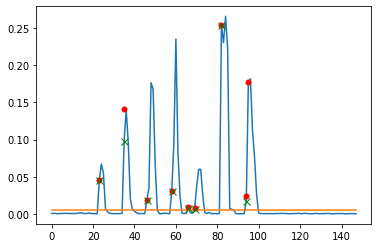

We detect 9 spikes (red "o"). The callback detects 8 spikes (green "x").


In [162]:
# How we detected spikes when training model, looking for rises above the threshold multiplier
# with no memory of the spikes that came before
prev_max = 1
spike_locations = []
spike_amplitudes = []
for b in range(len(listen.all_audio)):
    rec = listen.all_audio[b]
    new_max = np.absolute(rec).max()
    if new_max > THRESHOLD_MULTIPLIER * prev_max:
        spike_locations.append(b)
        spike_amplitudes.append(new_max)
    prev_max = new_max

# The spikes that the callback function discovered, what should similarly be looking for rises
# above the threshold multiplier, unless a spike was already detected in the last few batches
flattened_samples = [ r.flatten() for r in listen.all_audio ]
callback_spike_locations = []
callback_spike_amplitudes = []
sample_length = len(listen.all_audio[0])
for r in recordings:
    loc = [ np.array_equal(s, r[:sample_length]) for s in flattened_samples ].index(True)
    callback_spike_locations.append(loc)
    callback_spike_amplitudes.append(np.absolute(r[:sample_length].max()))
# print(callback_spike_locations)

# visualize the real and fictional spike locations
plt.plot([ float(max(r)) for r in listen.all_audio ])
plt.plot( [THRESHOLD_ABSOLUTE] * len(listen.all_audio) )
for i in range(len(spike_locations)):
    x = spike_locations[i]
    y = spike_amplitudes[i]
    plt.plot([x], [y], marker='o', markersize=5, color="red")
for i in range(len(callback_spike_locations)):
    x = callback_spike_locations[i]
    y = callback_spike_amplitudes[i]
    plt.plot([x], [y], marker='x', markersize=7, color="green")
plt.show()

print('We detect {} spikes (red "o"). The callback detects {} spikes (green "x").'.format(
    len(spike_locations), len(callback_spike_locations)))

Many of these overlap, but some of the callback results happened near the tops of each spike, which is strange. Let's check the previous maximum in each of those cases, to see if it's really beyond the threshold multiplier.

In [163]:
callback_spike_amplitude_jumps = []
for s in callback_spike_locations:
    spike_max = np.absolute(listen.all_audio[s].max())
    prev_max  = np.absolute(listen.all_audio[s-1].max())
    callback_spike_amplitude_jumps.append(spike_max / prev_max)
print(callback_spike_amplitude_jumps)
print([ m > THRESHOLD_MULTIPLIER for m in callback_spike_amplitude_jumps ])

[740.5, 146.13637, 42.4, 92.63636, 10.875, 7.0, 462.0, 38.733334]
[True, True, True, True, True, True, True, True]


Indeed, the ones that don't match, especially ones near the tops of the spikes, fail the threshold multiplier test. Let's figure out why that is.

FIXED! There was an erroneous return statement in the callback function, that was preventing proper updates of listen.prev_max.